<a href="https://colab.research.google.com/github/CShorten/Robust-Vector-Search/blob/main/Keras_CIFAR_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Apr 11 20:24:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow import keras

def get_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_cifar_10()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

def get_ResNet50(x_train, input_shape=(32,32,3)):
  normalization_layer = layers.experimental.preprocessing.Normalization()
  normalization_layer.adapt(x_train)

  inputs = layers.Input(shape=input_shape)
  normalized = normalization_layer(inputs)
  resnet_outputs = ResNet50(weights=None, include_top=False, input_shape=(32,32,3))(normalized)
  flattened = layers.Flatten()(resnet_outputs)
  dense_1 = layers.Dense(512, activation="relu", name = "dense1")(flattened)
  dense_2 = layers.Dense(512, activation="relu", name = "resnet_vectors")(dense_1) #naming the vectors for the vector model
  outputs = layers.Dense(10, activation="softmax")(dense_2)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

resnet_model = get_ResNet50(x_train)

In [ ]:
!pip install --upgrade imgaug # > /dev/null

     |████████████████████████████████| 948 kB 14.0 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
from imgaug import augmenters as iaa

randaugment = iaa.RandAugment(n=3, m=7)
rotate = iaa.Affine(rotate=(-45, 45))
crop = iaa.Crop(percent=(0, 0.2))
noise = iaa.AdditiveGaussianNoise(scale=(10, 30))

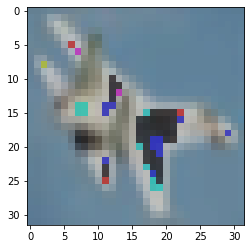

In [ ]:
import matplotlib.pyplot as plt
query_point = x_test[10]
query_point = randaugment(images=query_point.reshape(1,32,32,3))

plt.imshow(query_point.reshape(32,32,3));

In [ ]:
import tensorflow as tf

resnet_model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3),
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics = [
               keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

In [ ]:
resnet_model.load_weights("500.h5")
resnet_vector_model = keras.Model(inputs = resnet_model.input, outputs=resnet_model.get_layer("resnet_vectors").output)

In [ ]:
augs = [rotate, crop, noise, randaugment]
aug_names = ["Rotate", "Crop", "Noise", "RandAugment"]

print("Original Sets")
resnet_model.evaluate(x_train, y_train)
resnet_model.evaluate(x_test, y_test)
print("\n")

for i, aug in enumerate(augs):
  print(aug_names[i])
  aug_train = aug(images=x_train)
  aug_test = aug(images=x_test)
  resnet_model.evaluate(aug_train, y_train)
  resnet_model.evaluate(aug_test, y_test)
  print("\n")

Rotate
313/313 [==============================] - 3s 10ms/step - loss: 2.0932 - accuracy: 0.5032


Crop
313/313 [==============================] - 4s 12ms/step - loss: 0.9379 - accuracy: 0.7283


Noise
313/313 [==============================] - 4s 12ms/step - loss: 1.3417 - accuracy: 0.6376


RandAugment
313/313 [==============================] - 3s 10ms/step - loss: 0.8782 - accuracy: 0.7297




<h2> Embed Original Dataset </h2>

In [ ]:
!pip install docarray

     |████████████████████████████████| 623 kB 14.4 MB/s 
     |████████████████████████████████| 229 kB 67.3 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
  Created wheel for docarray: filename=docarray-0.12.1-py3-none-any.whl size=668885 sha256=4630b72c34cc31e5de583de9bb4f1ee708f2a483ffa372b0c24352fbc790b765
  Stored in directory: /root/.cache/pip/wheels/0c/3b/dd/46b1d92c2566378a9d0bd832f6d57ace237c2d8a1892c4f2d5
Successfully built docarray
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you hav

In [ ]:
from docarray import DocumentArray, Document

training_images = DocumentArray()
for img in x_train:
  training_images.append(Document(tensor=img))

In [ ]:
training_images

╭─────────────────── Documents Summary ────────────────────╮
│                                                          │
│   Length                 50000                           │
│   Homogenous Documents   True                            │
│   Common Attributes      ('id', 'tensor', 'embedding')   │
│   Multimodal dataclass   False                           │
│                                                          │
╰──────────────────────────────────────────────────────────╯
╭──────────────────────── Attributes Summary ─────────────────────────╮
│                                                                     │
│   Attribute   Data type          #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────────  │
│   embedding   ('EagerTensor',)   50000            False             │
│   id          ('str',)           50000            False             │
│   tensor      ('ndarray',)       50000            False             │
│                                                                     │
╰─────────────────────────────────────────────────────────────────────╯

In [ ]:
%%timeit
training_images.embed(resnet_vector_model, device="cuda")

1 loop, best of 5: 23.4 s per loop


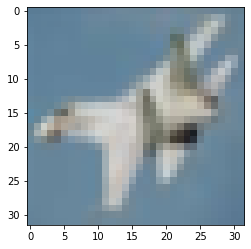

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_test[10])

In [ ]:
def robust_query_test(database, query, vector_model, augs, aug_names, K):
  query_doc = Document(tensor=query)
  query_doc.embed(vector_model)
  original_top16 = database.find(query_doc, limit=16)

  for i, aug in enumerate(augs):
    augmented_query_img = aug(image=query)
    augmented_query_doc = Document(tensor=augmented_query_img)
    print("Augmented query with: " + str(aug_names[i]))
    augmented_query_doc.display()
    augmented_query_doc.embed(vector_model)
    augmented_top16 = database.find(augmented_query_doc, limit=16)
    print("Top 16 Visualizations")
    print("Original")
    original_top16.plot_image_sprites()
    print(aug_names[i])
    augmented_top16.plot_image_sprites()
    print("Set Overlap at K = " + str(K))
    original_matchings = database.find(query_doc, limit=K)
    augmented_matchings = database.find(augmented_query_doc, limit=K)
    org_match_ids = set(original_matchings[:, "id"])
    aug_match_ids = set(augmented_matchings[:, "id"])
    set_union = len(org_match_ids.union(aug_match_ids))
    set_intersection = len(org_match_ids.intersection(aug_match_ids))
    set_metric = set_intersection / (set_union + set_intersection) * 100
    print("The original and augmented query share " + str(set_metric) + "% of their neighbors\n")

Augmented query with: Rotate


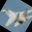

Top 16 Visualizations
Original


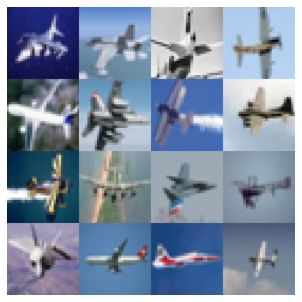

Rotate


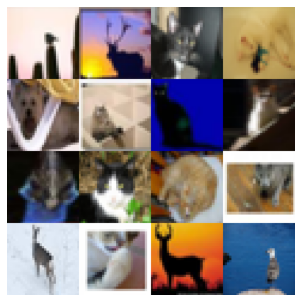

Set Overlap at K = 500
The original and augmented query share 1.0% of their neighbors



In [ ]:
robust_query_test(training_images, x_test[10], resnet_vector_model,
                  [rotate], ["Rotate"], 500)

In [ ]:
from PIL import Image
im = Image.fromarray(x_test[10])
im.save("airplane_test.jpg")